# 天气最高温度预测任务

我们要完成三项任务：
- 使用随机森林算法完成基本建模任务

基本任务需要我们处理数据，观察特征，完成建模并进行可视化展示分析

- 观察数据量与特征个数对结果影响

在保证算法一致的前提下，加大数据个数，观察结果变换。重新考虑特征工程，引入新特征后观察结果走势。

- 对随机森林算法进行调参，找到最合适的参数

掌握机器学习中两种经典调参方法，对当前模型进行调节

In [1]:
# 数据读取
import pandas as pd

features = pd.read_csv('data/temps.csv')
features.head(5)

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41


数据表中
* year,moth,day,week分别表示的具体的时间
* temp_2：前天的最高温度值
* temp_1：昨天的最高温度值
* average：在历史中，每年这一天的平均最高温度值
* actual：这就是我们的标签值了，当天的真实最高温度
* friend：这一列可能是凑热闹的，你的朋友猜测的可能值，咱们不管它就好了

# 数据大小

In [2]:
print('The shape of our features is:', features.shape)

The shape of our features is: (348, 9)


结果显示：The shape of our features is: (348, 9)，表示我们的数据一共有348条记录，每个样本有9个特征。如果你想观察一下各个指标的统计特性，还可以用.describe()来直接展示一下：

In [3]:
# 统计指标
features.describe()

,year,month,day,temp_2,temp_1,average,actual,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.511494,62.560345,59.760632,62.543103,60.034483
std,0.0,3.498380,8.772982,11.813019,11.767406,10.527306,11.794146,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,71.000000
max,2016.0,12.000000,31.000000,92.000000,92.000000,77.400000,92.000000,95.000000


其中包括了各个列的数量，如果有缺失数据，数量就有所减少，这里因为并不存在缺失值，所以各个列的数量值就都是348了，均值，标准差，最大最小值等指标在这里就都显示出来了。
对于时间数据，我们也可以进行一些转换，目的就是有些工具包在绘图或者计算的过程中，需要标准的时间格式：

In [4]:
# 处理时间数据
import datetime

# 分别得到年，月，日
years = features['year']
months = features['month']
days = features['day']

# datetime格式
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

In [5]:
dates[:5]

[datetime.datetime(2016, 1, 1, 0, 0),
 datetime.datetime(2016, 1, 2, 0, 0),
 datetime.datetime(2016, 1, 3, 0, 0),
 datetime.datetime(2016, 1, 4, 0, 0),
 datetime.datetime(2016, 1, 5, 0, 0)]

# 数据展示

In [5]:
# 准备画图
import matplotlib.pyplot as plt

%matplotlib inline

# 指定默认风格
plt.style.use('fivethirtyeight')

接着我们设计画图的布局，这里我们需要展示4项指标，分别为最高气温的标签值，前天，昨天，朋友预测的气温最高值。既然是4个图，那不妨就2*2的规模来画吧，这样会更清晰一点，对每个图再指定好其名字和坐标轴含义就可以了：

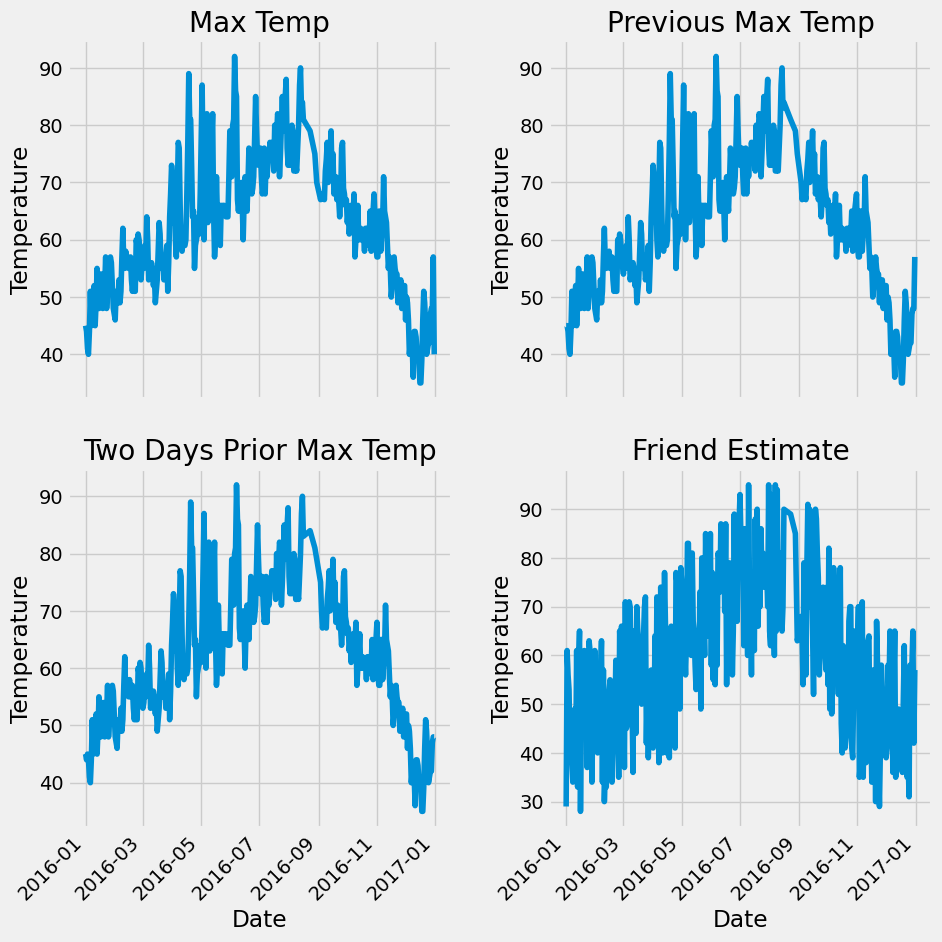

In [6]:
# 设置布局
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (10,10))
fig.autofmt_xdate(rotation = 45)

# 标签值
ax1.plot(dates, features['actual'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature'); ax1.set_title('Max Temp')

# 昨天
ax2.plot(dates, features['temp_1'])
ax2.set_xlabel(''); ax2.set_ylabel('Temperature'); ax2.set_title('Previous Max Temp')

# 前天
ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('Date'); ax3.set_ylabel('Temperature'); ax3.set_title('Two Days Prior Max Temp')

# 我的逗逼朋友
ax4.plot(dates, features['friend'])
ax4.set_xlabel('Date'); ax4.set_ylabel('Temperature'); ax4.set_title('Friend Estimate')

plt.tight_layout(pad=2)

各项指标看起来都还算正常，由于是国外的天气数据所以跟咱们的统计标准有些区别。接下来就要考虑数据预处理问题了，原始数据中在week列中并不是一些数值特征，而是表示周几的字符串，这些计算机可不认识，需要我们来转换一下：

# 数据预处理


### One-Hot Encoding

原始数据：

| week |
|------|
| Mon  |
| Tue  |
| Wed  |
| Thu  |
| Fri  |

编码转换后:

| Mon | Tue | Wed | Thu | Fri |
|-----|-----|-----|-----|-----|
| 1   | 0   | 0   | 0   | 0   |
| 0   | 1   | 0   | 0   | 0   |
| 0   | 0   | 1   | 0   | 0   |
| 0   | 0   | 0   | 1   | 0   |
| 0   | 0   | 0   | 0   | 1   |

In [7]:
# 独热编码
features = pd.get_dummies(features)
features.head(5)

,year,month,day,temp_2,temp_1,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,29,True,False,False,False,False,False,False
1,2016,1,2,44,45,45.7,44,61,False,False,True,False,False,False,False
2,2016,1,3,45,44,45.8,41,56,False,False,False,True,False,False,False
3,2016,1,4,44,41,45.9,40,53,False,True,False,False,False,False,False
4,2016,1,5,41,40,46.0,44,41,False,False,False,False,False,True,False


这样就完成了数据集中属性值的预处理工作，默认会把所有属性值都转换成独热编码的格式，并且还帮我们自动添加了后缀看起来更清晰了，这里我们其实也可以按照自己的方式来设置编码特征的名字的，如果大家遇到了一个不太熟悉的函数，想看一下其中的细节，有一个更直接的方法就是在notebook当中直接调help工具来看一下它的API文档，下面返回的就是其细节介绍，不光有各个参数说明，还有一些小例子，建议大家在使用的过程中一定要养成多练多查的习惯，查找解决问题的方法也是一个很重要的技能：

In [8]:
print (help(pd.get_dummies))

Help on function get_dummies in module pandas.core.reshape.encoding:

get_dummies(data, prefix=None, prefix_sep: 'str | Iterable[str] | dict[str, str]' = '_', dummy_na: 'bool' = False, columns=None, sparse: 'bool' = False, drop_first: 'bool' = False, dtype: 'NpDtype | None' = None) -> 'DataFrame'
    Convert categorical variable into dummy/indicator variables.

    Each variable is converted in as many 0/1 variables as there are different
    values. Columns in the output are each named after a value; if the input is
    a DataFrame, the name of the original variable is prepended to the value.

    Parameters
    ----------
    data : array-like, Series, or DataFrame
        Data of which to get dummy indicators.
    prefix : str, list of str, or dict of str, default None
        String to append DataFrame column names.
        Pass a list with length equal to the number of columns
        when calling get_dummies on a DataFrame. Alternatively, `prefix`
        can be a dictionary mapp

In [9]:
print('Shape of features after one-hot encoding:', features.shape)

Shape of features after one-hot encoding: (348, 15)


### 标签与数据格式转换

In [10]:
# 数据与标签
import numpy as np

# 标签
labels = np.array(features['actual'])

# 在特征中去掉标签
features= features.drop('actual', axis = 1)

# 名字单独保存一下，以备后患
feature_list = list(features.columns)

# 转换成合适的格式
features = np.array(features)

### 训练集与测试集

In [11]:
# 数据集切分
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25,
                                                                           random_state = 42)

In [12]:
print('训练集特征:', train_features.shape)
print('训练集标签:', train_labels.shape)
print('测试集特征:', test_features.shape)
print('测试集标签:', test_labels.shape)

训练集特征: (261, 14)
训练集标签: (261,)
测试集特征: (87, 14)
测试集标签: (87,)


# 建立一个基础的随机森林模型
万事俱备，我们可以来建立随机森林模型啦，首先导入工具包，先建立1000个树试试吧，其他参数先用默认值，之后我们会再深入到调参任务中：

In [13]:
# 导入算法
from sklearn.ensemble import RandomForestRegressor

# 建模
rf = RandomForestRegressor(n_estimators= 1000, random_state=42)

# 训练
rf.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=1000, random_state=42)

由于数据样本量还是非常小的，所以很快就可以得到结果了，这里我们先用MAPE指标来进行评估，也就是平均绝对百分误差，其实对于回归任务，评估方法还是比较多，给大家列出来几种，很简单就可以实现出来，也可以选择其他指标来进行评估：

# 测试

In [14]:
# 预测结果
predictions = rf.predict(test_features)

# 计算误差
errors = abs(predictions - test_labels)

# mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

print ('MAPE:',np.mean(mape))

MAPE: 6.011244187972058


# MAPE指标

# 可视化展示树

In [15]:
# 导入所需工具包
from sklearn.tree import export_graphviz
import pydot #pip install pydot

# 拿到其中的一棵树
tree = rf.estimators_[5]

# 导出成dot文件
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)


In [16]:
# 绘图
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# 展示
graph.write_png('tree.png'); 

![Decision Tree](tree.png)

In [17]:
print('The depth of this tree is:', tree.tree_.max_depth)

The depth of this tree is: 15


还是小一点吧。。。

In [18]:
# 限制一下树模型
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3, random_state=42)
rf_small.fit(train_features, train_labels)

# 提取一颗树
tree_small = rf_small.estimators_[5]

# 保存
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)

(graph, ) = pydot.graph_from_dot_file('small_tree.dot')

graph.write_png('small_tree.png');

![Small Decision Tree](images/small_tree.PNG)

### Annotated Version of Tree

![Annotated Decision Tree](images/small_tree_annotated.PNG)

## 特征重要性

In [19]:
# 得到特征重要性
importances = list(rf.feature_importances_)

# 转换格式
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# 排序
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# 对应进行打印
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: temp_1               Importance: 0.7
Variable: average              Importance: 0.19
Variable: day                  Importance: 0.03
Variable: temp_2               Importance: 0.02
Variable: friend               Importance: 0.02
Variable: month                Importance: 0.01
Variable: year                 Importance: 0.0
Variable: week_Fri             Importance: 0.0
Variable: week_Mon             Importance: 0.0
Variable: week_Sat             Importance: 0.0
Variable: week_Sun             Importance: 0.0
Variable: week_Thurs           Importance: 0.0
Variable: week_Tues            Importance: 0.0
Variable: week_Wed             Importance: 0.0


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

### 用最重要的特征再来试试

In [20]:
# 选择最重要的那两个特征来试一试
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

# 拿到这俩特征
important_indices = [feature_list.index('temp_1'), feature_list.index('average')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

# 重新训练模型
rf_most_important.fit(train_important, train_labels)

# 预测结果
predictions = rf_most_important.predict(test_important)

errors = abs(predictions - test_labels)

# 评估结果

mape = np.mean(100 * (errors / test_labels))

print('mape:', mape)

mape: 6.229055723613811


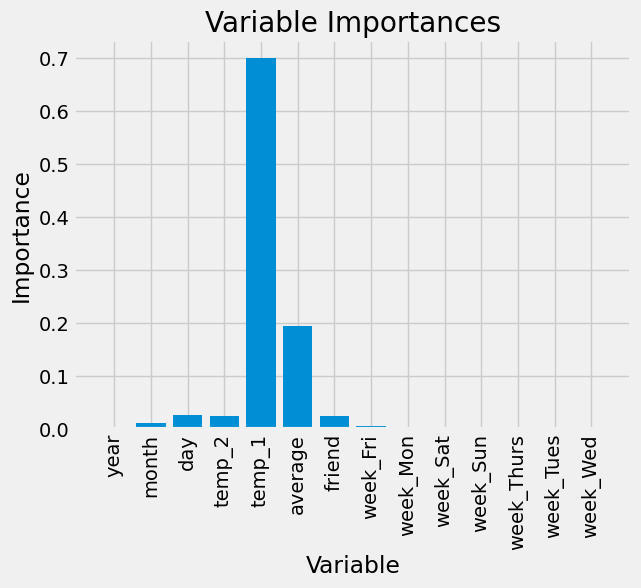

In [21]:
# 转换成list格式
x_values = list(range(len(importances)))

# 绘图
plt.bar(x_values, importances, orientation = 'vertical')

# x轴名字
plt.xticks(x_values, feature_list, rotation='vertical')

# 图名
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances'); 

### 预测值与真实值之间的差异

In [23]:
# 日期数据
months = features[:, feature_list.index('month')]
days = features[:, feature_list.index('day')]
years = features[:, feature_list.index('year')]

# 转换日期格式
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# 创建一个表格来存日期和其对应的标签数值
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})

# 同理，再创建一个来存日期和其对应的模型预测值
months = test_features[:, feature_list.index('month')]
days = test_features[:, feature_list.index('day')]
years = test_features[:, feature_list.index('year')]

test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions}) 

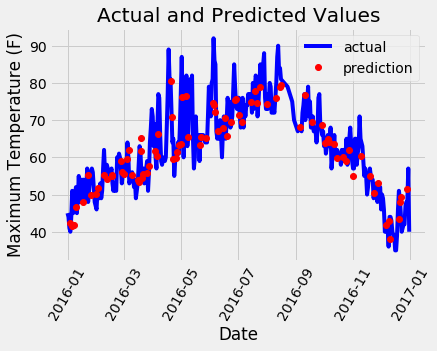

In [24]:
# 真实值
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')

# 预测值
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()

# 图名
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');


看起来还可以，这个走势我们的模型已经基本能够掌握了，接下来我们要再深入到数据中了，考虑几个问题：
1.如果可以利用的数据量增大，会对结果产生什么影响呢？
2.加入新的特征会改进模型效果吗？此时的时间效率又会怎样？